In [15]:
import os
import sys

import cv2
import numpy as np
import pandas as pd
import random

from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

sys.path.insert(0,'..')  # imports hack

%matplotlib inline

In [2]:
run = '20230327_193043_efficientnet-b3'

# Images Analysis

In [3]:
df_train = pd.read_csv('../data/Train.csv')

len(df_train)

2002

In [4]:
df_test = pd.read_csv('../data/Test.csv')

len(df_test)

858

In [5]:
df_preds = pd.read_csv(f"../runs/{run}/{run}_preds.csv")

len(df_preds)

858

In [6]:
os.getcwd()

images_dir = "../data/TreeImages/"

all_images = os.listdir(images_dir)

In [7]:
def extract_image_stats(images_dir):
    """
    Iterate through images in a directory, and extract the image min, max, mean, and std for each channel and 
    averaged across all channels, add these data as rows in a pandas dataframe
    
    Parameters:
    images_dir (str): Directory containing the images
    
    Returns:
    stats_df (pandas.DataFrame): Dataframe containing image stats for each image
    """

    stats = []
    for filename in os.listdir(images_dir):
        img = cv2.imread(os.path.join(images_dir, filename))
            
        channels = {'b': img[:,:,0], 'g': img[:,:,1], 'r': img[:,:,2]}
        
        img_stats = {'ImageId': filename, 'img_min': img.min(), 'img_max': img.max(), 'img_mean': img.mean(), 'img_std': img.std()}

        channel_stats = [{f"min_{c}": v.min(), f"max_{c}": v.max(), f"std_{c}": v.std(), f"mean_{c}": v.mean()} for c, v in channels.items()]
        channel_stats = {k: v for d in channel_stats for k, v in d.items()}
        stats.append(dict(**img_stats, **channel_stats))
        
    return pd.DataFrame(stats).round(decimals=2)

In [8]:
df = extract_image_stats(images_dir)

In [9]:
df_preds = pd.merge(df_preds, df, on='ImageId', how='inner')

In [10]:
n_blanks = len(df_preds[df_preds["img_max"] == 0])

blank_targets = df_preds[df_preds["img_max"] == 0]["Target"].sum()

print(f"Sum of all counts for {n_blanks} blank images = {blank_targets}")

Sum of all counts for 224 blank images = 0.0


# View augmented images

In [11]:
from torchvision import transforms

from core.utils import get_params
from core.efficientnet import transform_images
from core.efficientnet import TreeImagesDataset

In [12]:
params = get_params({"command": "efficientnet", "params_file": "../params.yaml"}) 

[2023-03-29 13:53:09,030] [notebooks] [core.utils] [596108] [INFO] Loaded efficientnet params: ../params.yaml.
[2023-03-29 13:53:09,031] [notebooks] [core.utils] [596108] [INFO] --- Parameter: model_name: efficientnet-b3
[2023-03-29 13:53:09,032] [notebooks] [core.utils] [596108] [INFO] --- Parameter: val_split: 0.15
[2023-03-29 13:53:09,032] [notebooks] [core.utils] [596108] [INFO] --- Parameter: learning_rate: 0.001
[2023-03-29 13:53:09,033] [notebooks] [core.utils] [596108] [INFO] --- Parameter: batch_size: 5
[2023-03-29 13:53:09,033] [notebooks] [core.utils] [596108] [INFO] --- Parameter: max_epochs: 100
[2023-03-29 13:53:09,034] [notebooks] [core.utils] [596108] [INFO] --- Parameter: early_stopping_patience: 3
[2023-03-29 13:53:09,034] [notebooks] [core.utils] [596108] [INFO] --- Parameter: normalize - rgb_means: [0.29251013, 0.35511252, 0.24754053]
[2023-03-29 13:53:09,034] [notebooks] [core.utils] [596108] [INFO] --- Parameter: normalize - rgb_stds: [0.12808342, 0.12873866, 0.10

In [80]:
from PIL import Image
img = Image.open('../data/TreeImages/Id_1z2vrulnga.png').convert('RGB')

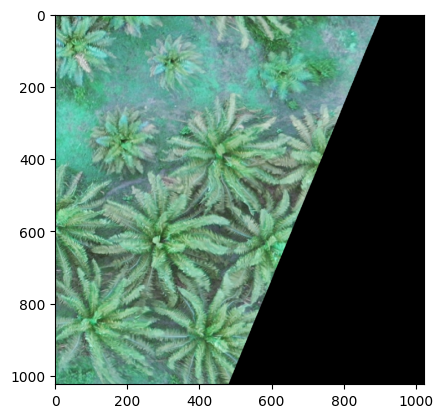

In [67]:
img = cv2.imread('../data/TreeImages/Id_1z2vrulnga.png')
plt.imshow(img)

In [81]:
def rescale_image(img):
    
    img = np.array(img)
    
    H, W = img.shape[0:2]
    
    if img.max(): # image has data
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        largest_contour = max(contours, key=cv2.contourArea)

        epsilon = 0.01 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)

        approx = np.reshape(approx, (approx.shape[0], -1)).astype('float32')

        if len(approx) != 4:
            x, y, w, h = cv2.boundingRect(largest_contour)
            approx = np.array([[x, y], [x, y+h -1], [x+w -1, y+h -1], [x+w -1, y] ], dtype=np.float32)

        pts_dst = np.array([[0, 0], [0, H-1], [W-1, H-1], [W-1, 0]], dtype=np.float32)

        M = cv2.getPerspectiveTransform(approx, pts_dst)

        img_warped = cv2.warpPerspective(img, M, (H, W))
    else:
        img_warped = img

    return img_warped

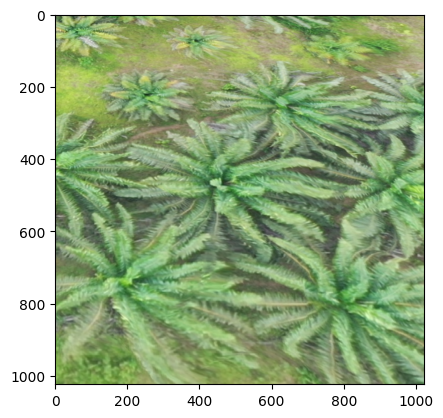

In [82]:
plt.imshow(rescale_image(img))

In [83]:
normalizer = transforms.Normalize(
    #mean=[0.29251013, 0.35511252, 0.24754053],
    #mean=[0.5, 0.5, 0.5],
    mean=(0.485, 0.456, 0.406), 
    #std=[0.12808342, 0.12873866, 0.10857158]
    #std=[0.5, 0.5, 0.5],
    std=(0.485, 0.456, 0.406), 

)

train_transform = transforms.Compose(
    [
        rescale_image,
        transforms.ToTensor(),
        #transforms.Resize([1024, 1024]),
        #ColorJitter(brightness=.5, hue=.3),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        #transforms.GaussianBlur(11, sigma=(0.1, 2.0)),
        #transforms.GaussianBlur(71),
        #transforms.RandomApply([transforms.GaussianBlur(5)], p=1.0),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        normalizer,
    ])  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

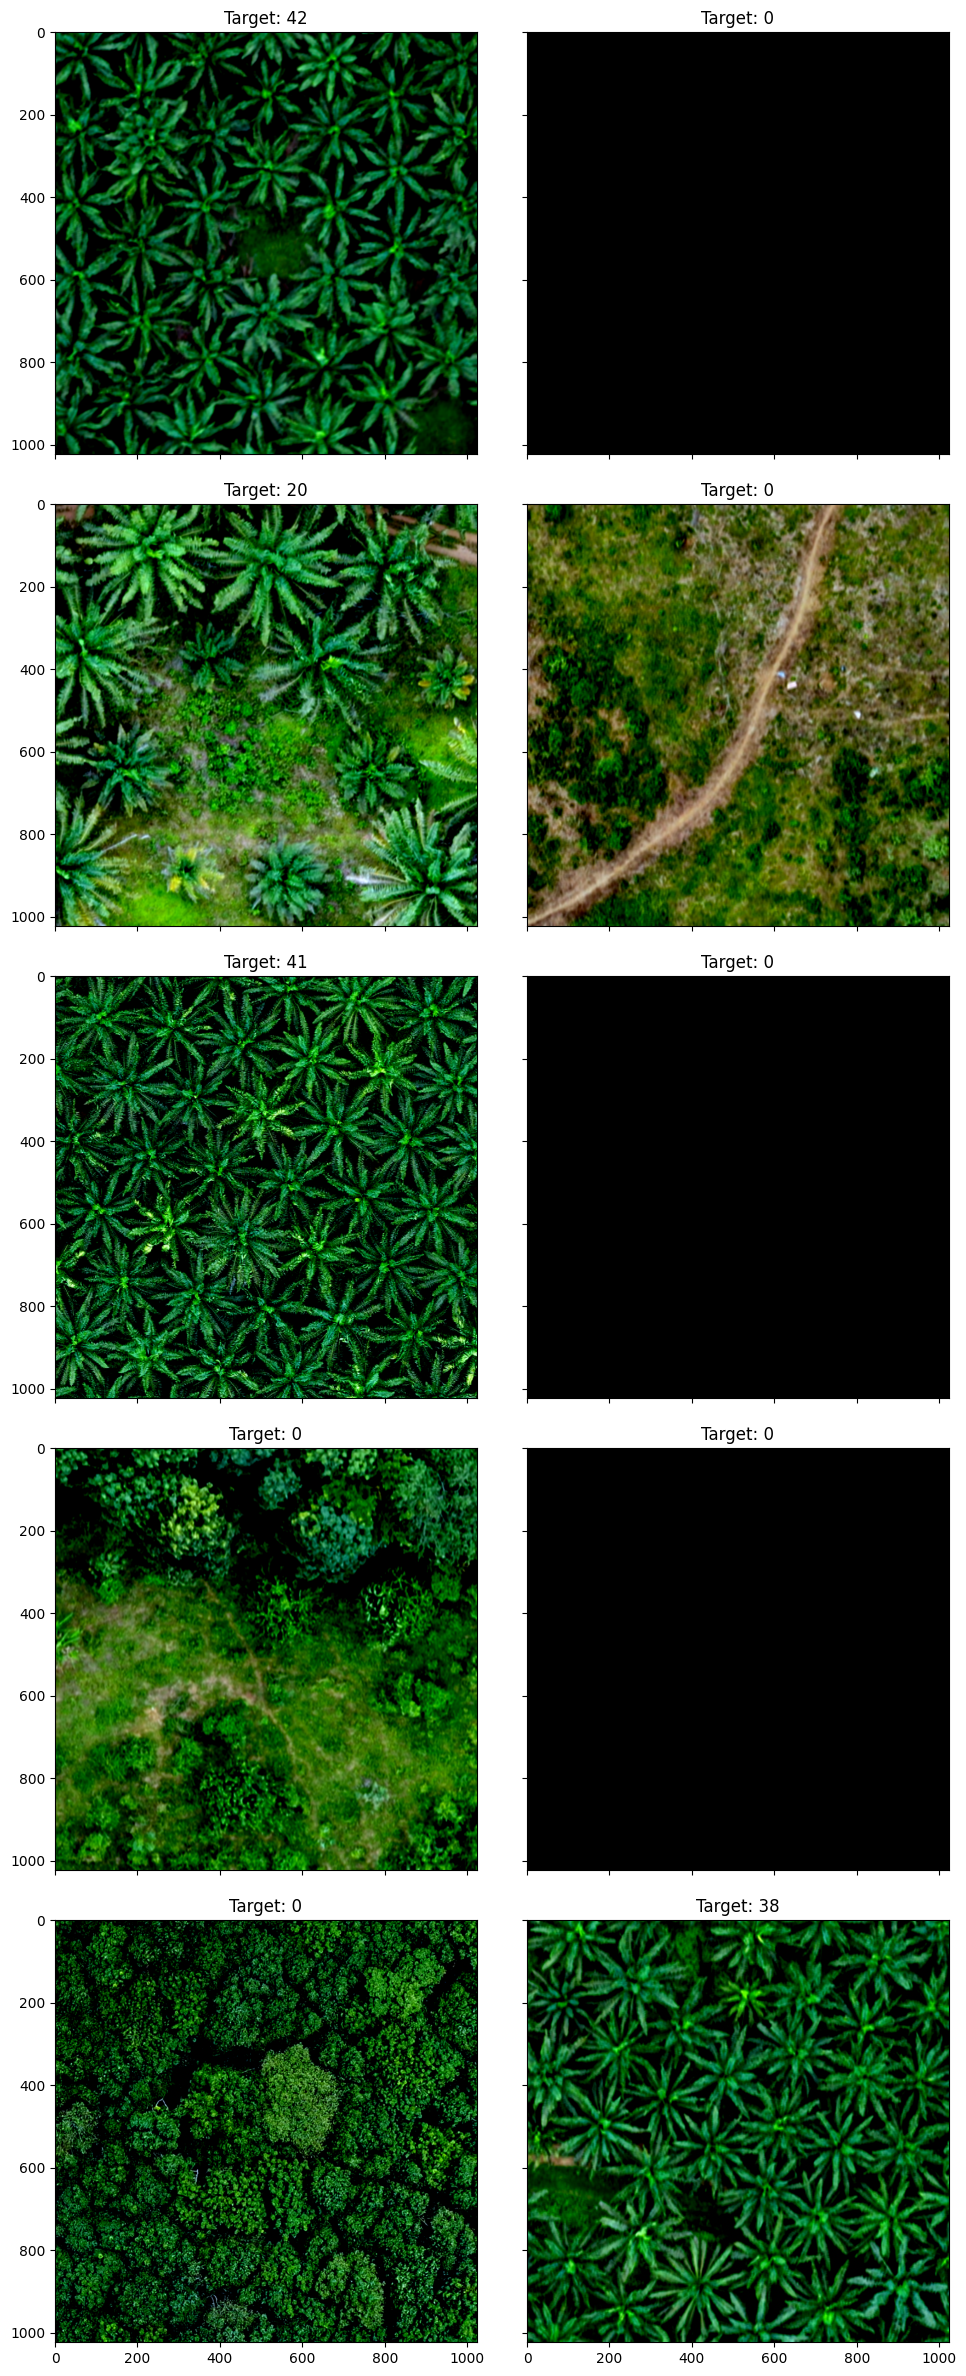

In [85]:
train_dataset = TreeImagesDataset(df_train, '../data/TreeImages', transform=train_transform)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

X, y = next(iter(train_dataloader))

targets = [int(target) for target in list(y)]

fig = plt.figure(figsize=(20, 30))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 2), axes_pad=0.5,)


for i, (ax, img) in enumerate(zip(grid, targets)):
    target = targets[i]
    ax.set(title=f"Target: {target}")
    ax.imshow(X[i].squeeze().permute(1, 2, 0))

# Images Montage

In [20]:
def plot_50_images(df, images_dir):
    df = df.sample(50)
    
    fig = plt.figure(figsize=(20, 30))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(10, 5),
                     axes_pad=0.5,
                     )

    
    file_names = [file_name for file_name in df['ImageId']]
    targets = [t for t in df['Target']]

    for i, (ax, img) in enumerate(zip(grid, targets)):
        file_name = file_names[i]
        ax.set(title=f"{file_name.split('.png')[0]}: {targets[i]:.2f}")
        ax.imshow(cv2.imread(os.path.join(images_dir, file_name)))

In [21]:
df_target_zero = df_preds[(df_preds["Target"] == 0) & (df_preds["img_max"] != 0)] # excluding blanks

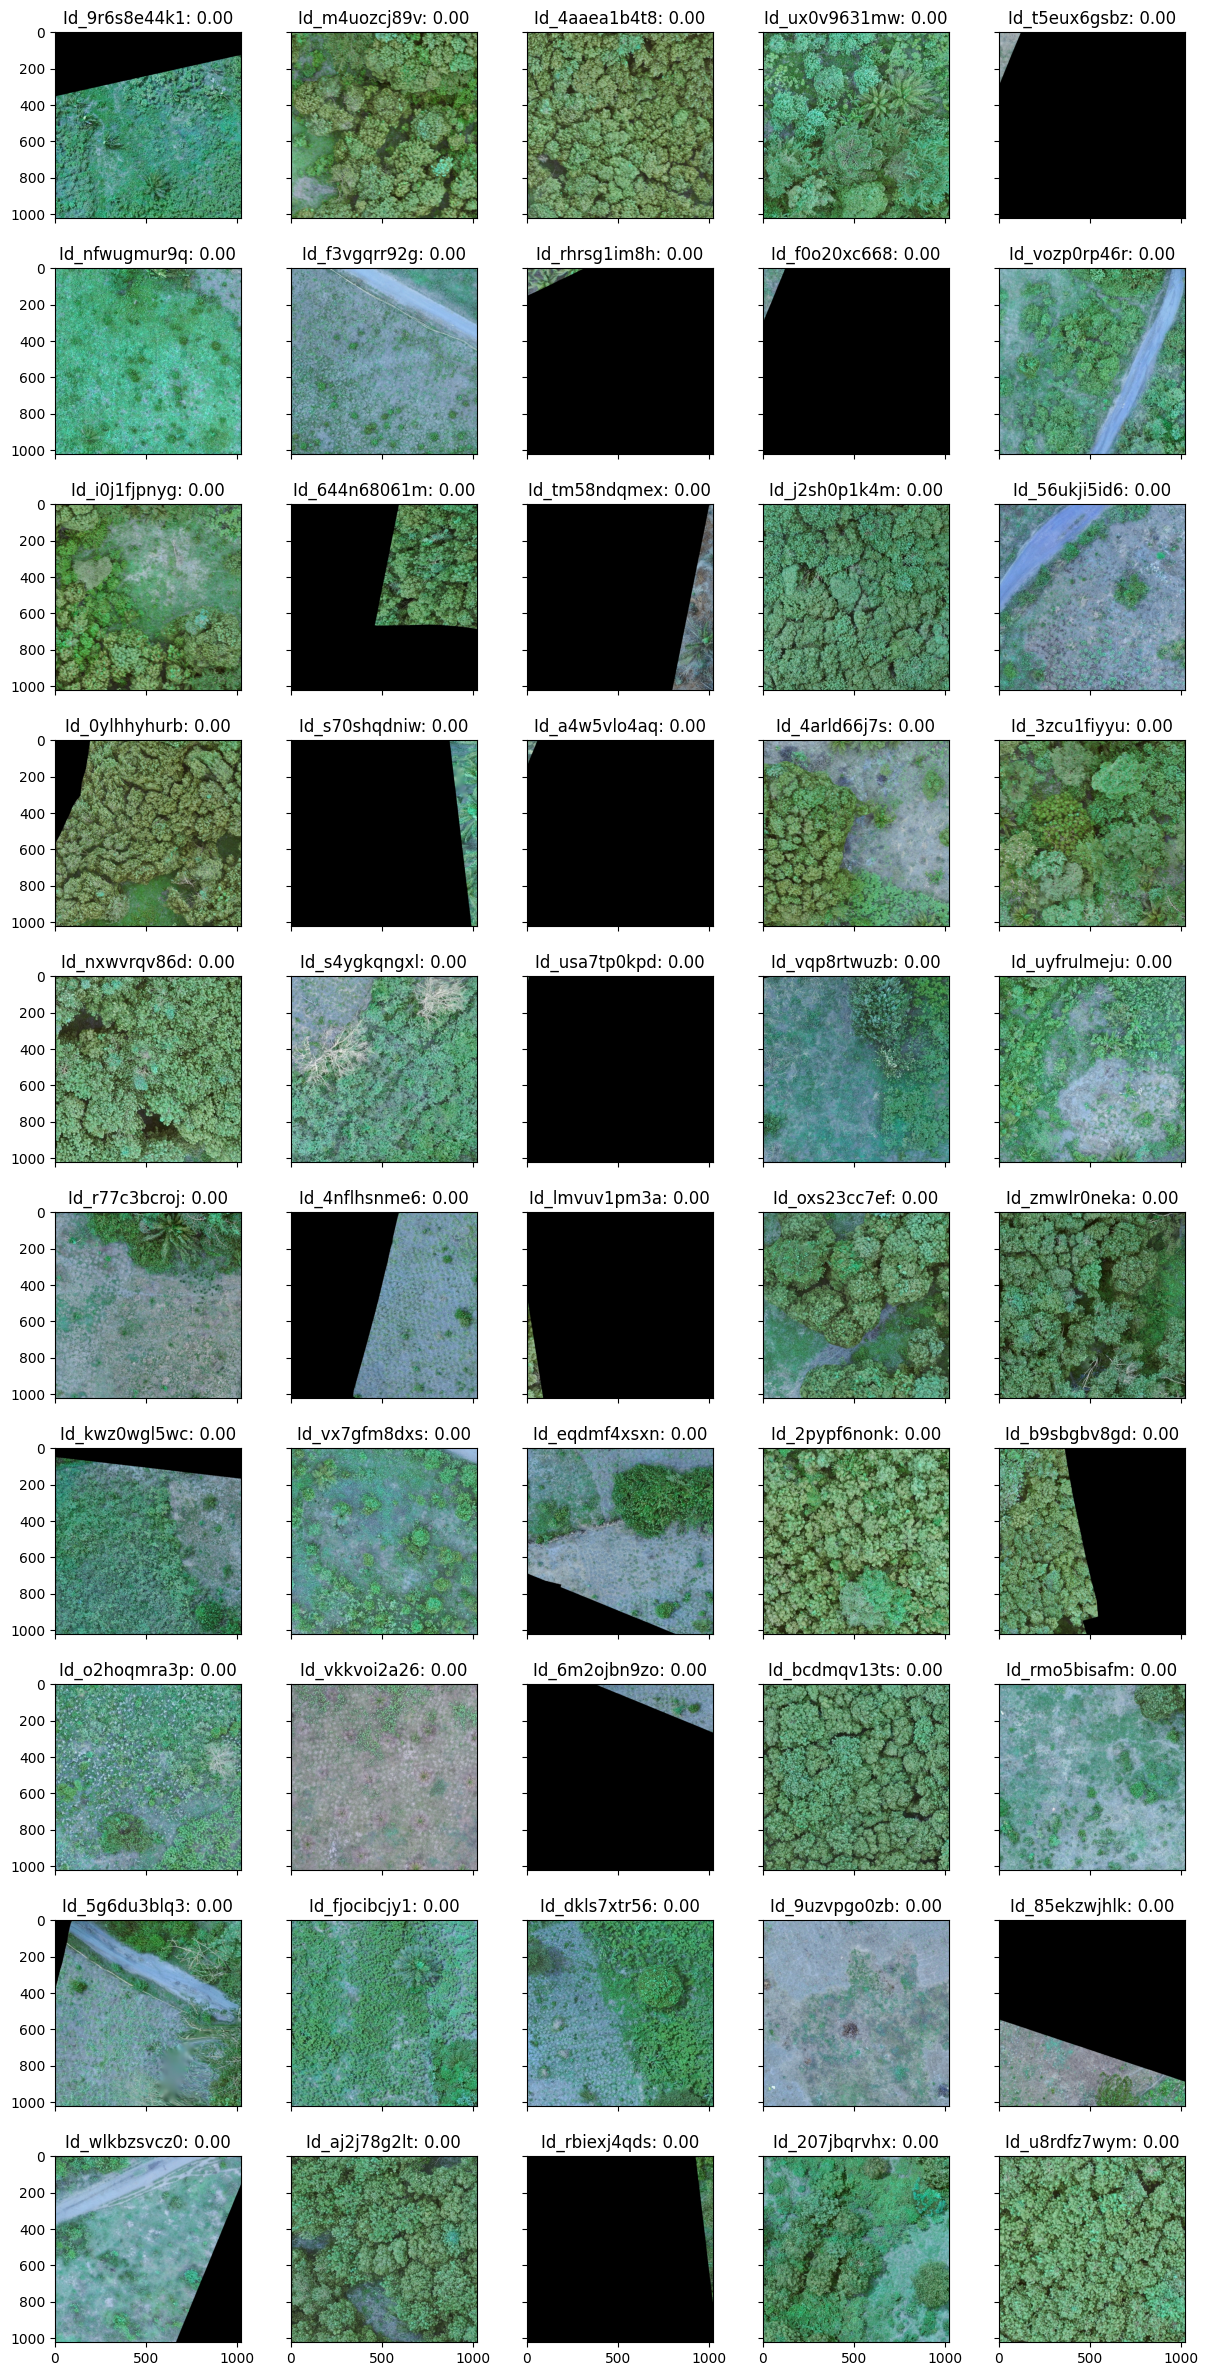

In [22]:
plot_50_images(df_target_zero, images_dir)

In [ ]:
    fig = plt.figure(figsize=(20, 30))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(10, 5),
                     axes_pad=0.5,
                     )
    
    df_target_zero = df_target_zero.sample(50)

    file_names = [file_name for file_name in df_target_zero['ImageId']]

    targets = [t for t in df_target_zero['Target']]

    for i, (ax, img) in enumerate(zip(grid, file_names)):
        file_name = file_names[i]
        ax.set(title=f"{file_name.split('.png')[0]}: {targets[i]:.2f}")
        ax.imshow(cv2.imread(os.path.join(images_dir, file_name)))

In [ ]:
fig = plt.figure(figsize=(20, 30))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 5),
                 axes_pad=0.5,
                 )

file_names = [file_name for file_name in df_random['ImageId']]

targets = [t for t in df_random['Target']]

for i, (ax, img) in enumerate(zip(grid, file_names)):
    file_name = file_names[i]
    ax.set(title=f"{file_name.split('.png')[0]}: {int(targets[i])}")
    ax.imshow(cv2.imread(os.path.join(images_dir, file_name)))

In [ ]:
x = df_preds[df_preds["img_max"] == 0]["Target"].sum()

In [ ]:
df_preds.loc[df_preds["Target"].notnull()]['Target'].hist(bins=int(df_preds["Target"].max())).set_title('Target distribution')

In [ ]:
df.loc[df["Target"].notnull()]['Target'].hist(bins=int(df["Target"].max())).set_title('Target distribution')

In [ ]:
n_images = len(df)
n_empty = sum(df['img_mean'] == 0)


print(f"Number of images: {n_images}")
print(f"Number of empty images: {n_empty}")
print(f"% of empty images: {n_empty / n_images * 100:.2f}")


In [ ]:
df_non_zero = df.loc[~(df['img_mean'] == 0)]

In [ ]:
df_non_zero["img_mean"].hist(bins=int(df_non_zero["img_mean"].max())).set_title('Non-empty images mean pixel values')

In [ ]:
df_non_zero["img_std"].hist(bins=int(df_non_zero["img_std"].max())).set_title('Non-empty images std pixel values')

In [ ]:
df_non_zero

# Correlations

In [ ]:
df_target = df.loc[df["Target"].notnull()]

df_target[df_target.columns[1:]].corr()['Target'][:].sort_values(ascending=False)

# Images Montage

In [ ]:
df_random = df.loc[df['Target'].notnull()].sample(n=50, random_state=42)

In [ ]:
fig = plt.figure(figsize=(20, 30))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 5),
                 axes_pad=0.5,
                 )

file_names = [file_name for file_name in df_random['ImageId']]

targets = [t for t in df_random['Target']]

for i, (ax, img) in enumerate(zip(grid, file_names)):
    file_name = file_names[i]
    ax.set(title=f"{file_name.split('.png')[0]}: {int(targets[i])}")
    ax.imshow(cv2.imread(os.path.join(images_dir, file_name)))

# Scale Images

In [ ]:
#img = cv2.imread('../data/TreeImages/Id_0tko96xpuj.png')
#img = cv2.imread('../data/TreeImages/Id_0egm0q0k5w.png')
#img = cv2.imread('../data/TreeImages/Id_1w6bxoo1kl.png')
#img = cv2.imread('../data/TreeImages/Id_1z2vrulnga.png')
#img = cv2.imread('../data/TreeImages/Id_hycwtqhorz.png')
#img = cv2.imread('../data/TreeImages/Id_omaf8y5myk.png')

In [ ]:
def transform_images(img):
    H, W = img.shape[0:2]
    
    if img.max(): # image has data
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

        # Find contours of non-zero regions
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Get the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
                
        # Get the polygon that describes the contour
        epsilon = 0.01 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)

        approx = np.reshape(approx, (approx.shape[0], -1)).astype('float32')

        if len(approx) != 4:
            x, y, w, h = cv2.boundingRect(largest_contour)
            approx = np.array([[x, y], [x, y+h -1], [x+w -1, y+h -1], [x+w -1, y] ], dtype=np.float32)

        # Define the target coordinates of the square
        pts_dst = np.array([[0, 0], [0, H-1], [W-1, H-1], [W-1, 0]], dtype=np.float32)

        # Compute the perspective transform matrix
        M = cv2.getPerspectiveTransform(approx, pts_dst)

        # Warp the image using the perspective transform matrix
        img_warped = cv2.warpPerspective(img, M, (H, W))
    else:
        img_warped = img

    return img_warped

In [ ]:
fig = plt.figure(figsize=(20, 30))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 5),
                 axes_pad=0.5,
                 )

file_names = [file_name for file_name in df_random['ImageId']]

targets = [t for t in df_random['Target']]

for i, (ax, img) in enumerate(zip(grid, file_names)):
    file_name = file_names[i]
    ax.set(title=f"{file_name.split('.png')[0]}: {int(targets[i])}")
    ax.imshow(transform_images(cv2.imread(os.path.join(images_dir, file_name))))